In [1]:
import pandas as pd
import numpy as np
from transformers import RobertaTokenizer, RobertaModel
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MultiLabelBinarizer
from tqdm import tqdm
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    multilabel_confusion_matrix, mutual_info_score
)
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import argparse
import os
import json
from datetime import datetime
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier

In [2]:
# remove all the warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Add GPU count check at the top level
def get_available_gpus():
    """Get the number of available GPUs and their IDs"""
    if not torch.cuda.is_available():
        return 0, []
    
    n_gpus = torch.cuda.device_count()
    gpu_ids = list(range(n_gpus))
    return n_gpus, gpu_ids


In [4]:
# Add hybrid feature selection function
def hybrid_feature_selection(texts, labels_encoded, mlb, top_k_filter=20, top_k_final=10, vectorizer=None, random_seed=42):
    """
    Perform hybrid feature selection using both filter and wrapper methods.
    
    Args:
        texts (pd.Series): Series of text data
        labels_encoded (np.array): One-hot encoded labels
        mlb (MultiLabelBinarizer): Label encoder used for transforming labels
        top_k_filter (int): Number of labels to retain after filter stage
        top_k_final (int): Final number of labels to select
        vectorizer (object): Text vectorizer with fit_transform method. If None, uses simple word count
        random_seed (int): Random seed for reproducibility
        
    Returns:
        tuple: Selected indices, selected label names, and feature importance scores
    """
    print(f"Starting hybrid feature selection to select {top_k_final} out of {labels_encoded.shape[1]} labels...")
    
    # If no vectorizer provided, create a simple one using sklearn's CountVectorizer
    if vectorizer is None:
        from sklearn.feature_extraction.text import CountVectorizer
        vectorizer = CountVectorizer(max_features=5000)
    
    # Transform texts to feature vectors
    print("Vectorizing text data...")
    X_vec = vectorizer.fit_transform(texts)
    
    # STEP 1: Filter Method - Use chi-square test and mutual information
    print("Applying filter methods...")
    
    # Store scores from multiple filter methods
    feature_scores = np.zeros(labels_encoded.shape[1])
    
    # Chi-square test for each label
    for i in range(labels_encoded.shape[1]):
        chi_scores = chi2(X_vec, labels_encoded[:, i])
        feature_scores[i] += chi_scores[0].mean()  # Add chi-square statistic
    
    # Mutual information for each label
    for i in range(labels_encoded.shape[1]):
        mi_score = mutual_info_classif(X_vec, labels_encoded[:, i], random_state=random_seed)
        feature_scores[i] += mi_score.mean() * 10  # Scale and add MI score
    
    # Get top-k features from filter methods
    filter_selected_indices = np.argsort(-feature_scores)[:top_k_filter]
    filter_selected_labels = np.array(mlb.classes_)[filter_selected_indices]
    
    print(f"Filter stage selected {len(filter_selected_indices)} labels")
    
    # STEP 2: Wrapper Method - Use a lightweight model (Random Forest) to evaluate feature subsets
    print("Applying wrapper method...")
    
    # Train a Random Forest model on the filtered features
    rf = RandomForestClassifier(n_estimators=100, random_state=random_seed, n_jobs=-1)
    X_filtered = labels_encoded[:, filter_selected_indices]
    
    # For wrapper method, we'll create a matrix where each sample is label presence/absence
    # and the target is other labels - a proxy for how well each label predicts others
    importance_scores = np.zeros(len(filter_selected_indices))
    
    # For each label, train a model to predict it using the other labels
    for i in tqdm(range(len(filter_selected_indices)), desc="Wrapper evaluation"):
        # Current target label
        y = X_filtered[:, i]
        
        # Features (other labels)
        X_others = np.delete(X_filtered, i, axis=1)
        
        # Train model
        rf.fit(X_others, y)
        
        # Score based on model performance
        accuracy = rf.score(X_others, y)
        importance_scores[i] = accuracy
    
    # STEP 3: Combine scores to select final features
    final_scores = 0.6 * feature_scores[filter_selected_indices] + 0.4 * importance_scores
    final_selected_indices = filter_selected_indices[np.argsort(-final_scores)[:top_k_final]]
    final_selected_labels = np.array(mlb.classes_)[final_selected_indices]
    
    print(f"Final selection: {len(final_selected_labels)} labels")
    print("Selected labels:", final_selected_labels)
    
    return final_selected_indices, final_selected_labels, final_scores


In [5]:
class IssueDataset(Dataset):
    """
    Dataset for processing text data and multi-label classification.

    Args:
        texts (pd.Series): Series of input texts.
        labels (list or pd.Series): Corresponding labels (one-hot encoded for multi-label).
        tokenizer (transformers.PreTrainedTokenizer): Tokenizer for converting text to tokens.
        max_length (int): Maximum length of tokenized sequences (default is 512).
    """
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts.reset_index(drop=True)
        # Reset index for labels if it's a pandas Series.
        if isinstance(labels, pd.Series):
            self.labels = labels.reset_index(drop=True)
        else:
            self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])
        encodings = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            return_tensors='pt'
        )
        
        # For multi-label classification, ensure we're passing the full label array
        # and not just a single value
        label = self.labels[idx]
        
        # Make sure we're getting a proper multi-dimensional label array
        # and not flattening it incorrectly
        if isinstance(label, (list, np.ndarray)):
            # Convert directly to tensor without modifying shape
            label = torch.tensor(label, dtype=torch.float)
        else:
            # If it's not already an array-like structure, this is likely a mistake
            # as we expect multi-label one-hot encoded data
            raise ValueError(f"Expected multi-dimensional label array but got {type(label)}")
        
        return {
            'input_ids': encodings['input_ids'].flatten(),
            'attention_mask': encodings['attention_mask'].flatten(),
            'labels': label
        }
   

In [6]:
class CodeBERTClassifier(nn.Module):
    """
    A classifier model based on CodeBERT for multi-label classification.
    
    This model uses a pre-trained CodeBERT model as the encoder and adds a 
    classification head on top with sigmoid activation for multi-label output.
    
    Args:
        num_labels (int): Number of classes in the multi-label classification task.
    """
    def __init__(self, num_labels):
        super().__init__()
        self.codebert = RobertaModel.from_pretrained('microsoft/codebert-base')
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(768, num_labels)
        # Freeze all parameters in CodeBERT
        for param in self.codebert.parameters():
            param.requires_grad = False
        # Unfreeze pooler parameters for fine-tuning
        for param in self.codebert.pooler.parameters():
            param.requires_grad = True
        # Unfreeze parameters of the last 3 encoder layers
        for layer in self.codebert.encoder.layer[-3:]:
            for param in layer.parameters():
                param.requires_grad = True

    def forward(self, input_ids, attention_mask):
        outputs = self.codebert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        # Return raw logits for BCEWithLogitsLoss (sigmoid will be applied in the loss function)
        return self.classifier(pooled_output)
  

In [7]:
class EarlyStopping:
    """
    Early stopping to stop training when the validation loss does not improve sufficiently.
    
    For multi-label classification, we consider a loss improvement when 
    the validation loss decreases by at least min_delta.
    
    Args:
        patience (int): Number of epochs to wait for an improvement before stopping.
        min_delta (float): Minimum decrease in the monitored loss to qualify as an improvement.
    """
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def reset(self):
        """Reset the early stopping state."""
        self.counter = 0
        self.best_loss = None
        self.early_stop = False



In [8]:
def train_epoch(model, loader, criterion, optimizer, device, threshold=0.5, early_stopping=None):
    """
    Train the model for one epoch, computing loss and metrics for multi-label classification.

    Args:
        model (nn.Module): The multi-label classification model.
        loader (DataLoader): Training DataLoader.
        criterion: Loss function (BCEWithLogitsLoss).
        optimizer: Optimization algorithm.
        device: Device to perform training (CPU or GPU).
        threshold (float): Threshold for binary predictions (default is 0.5).
        early_stopping (EarlyStopping, optional): Instance to monitor improvement in loss.

    Returns:
        tuple: Average loss, Hamming accuracy, and a flag indicating if early stopping was triggered.
    """
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    for batch in tqdm(loader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        # Apply sigmoid and threshold for predictions
        predictions = torch.sigmoid(outputs) >= threshold
        all_preds.append(predictions.cpu().detach().numpy())
        all_labels.append(labels.cpu().detach().numpy())
    
    # Calculate metrics for multi-label classification
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    
    # Use subset accuracy (exact match) for a strict measure
    exact_match = (all_preds == all_labels).all(axis=1).mean()
    
    avg_loss = total_loss / len(loader)
    
    if early_stopping:
        early_stopping(avg_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            return avg_loss, exact_match, True
            
    return avg_loss, exact_match, False
 

In [9]:
def validate(model, loader, criterion, device, threshold=0.5):
    """
    Evaluate the model on provided validation data for multi-label classification.

    Args:
        model (nn.Module): The multi-label classification model.
        loader (DataLoader): Validation DataLoader.
        criterion: Loss function (BCEWithLogitsLoss).
        device: Device to perform evaluation.
        threshold (float): Threshold for binary predictions (default is 0.5).

    Returns:
        tuple: Average loss, various accuracy metrics, precision, recall, and F1 score.
    """
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            # Apply sigmoid and threshold for predictions
            predictions = (torch.sigmoid(outputs) >= threshold).float()
            all_preds.append(predictions.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    
    # Calculate different multi-label metrics
    
    # 1. Exact Match / Subset Accuracy (all labels must be correct)
    subset_accuracy = (all_preds == all_labels).all(axis=1).mean()
    
    # 2. Hamming Accuracy (fraction of correct labels)
    # Original implementation: hamming_accuracy = (all_preds == all_labels).mean()
    
    # Modified Hamming Accuracy - Focus on positive cases only (where true label is 1)
    # This gives the accuracy of predictions where the ground truth is positive
    positive_cases = (all_labels == 1)
    if np.sum(positive_cases) > 0:  # Avoid division by zero
        hamming_accuracy_positive = np.sum((all_preds == all_labels) & positive_cases) / np.sum(positive_cases)
    else:
        hamming_accuracy_positive = 0.0
    
    # 3. Jaccard Similarity (intersection over union)
    def jaccard_score(y_true, y_pred):
        intersection = np.logical_and(y_true, y_pred).sum(axis=1)
        union = np.logical_or(y_true, y_pred).sum(axis=1)
        # Create a float array for output to avoid type casting error
        result = np.zeros_like(intersection, dtype=float)
        # Avoid division by zero
        np.divide(intersection, union, out=result, where=union!=0)
        return np.mean(result)
    
    jaccard_sim = jaccard_score(all_labels.astype(bool), all_preds.astype(bool))
    
    # Sample-based metrics - Each sample contributes equally regardless of number of labels
    precision = precision_score(all_labels, all_preds, average='samples', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='samples', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='samples', zero_division=0)
    
    return (total_loss / len(loader), 
            {"exact_match": subset_accuracy, 
             "hamming": hamming_accuracy_positive,  # Changed to use positive-only accuracy
             "jaccard": jaccard_sim}, 
            precision, recall, f1)

In [10]:
def plot_multilabel_confusion_matrix(y_true, y_pred, class_names):
    """
    Plot confusion matrices for each label in a multi-label classification problem.
    
    Args:
        y_true (numpy.ndarray): True binary labels.
        y_pred (numpy.ndarray): Predicted binary labels.
        class_names (list): Names of the classes/labels.
    """
    confusion_matrices = multilabel_confusion_matrix(y_true, y_pred)
    
    num_classes = len(class_names)
    fig, axes = plt.subplots(nrows=(num_classes + 3) // 4, ncols=min(4, num_classes), 
                             figsize=(20, 5 * ((num_classes + 3) // 4)))
    if num_classes == 1:
        axes = np.array([axes])  # Make it indexable for single class
    axes = axes.flatten()
    
    for i, matrix in enumerate(confusion_matrices):
        if i < num_classes:  # Ensure we don't exceed the number of classes
            ax = axes[i]
            sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', ax=ax)
            ax.set_title(f'Label: {class_names[i]}')
            ax.set_xlabel('Predicted')
            ax.set_ylabel('True')
            ax.set_xticklabels(['Negative', 'Positive'])
            ax.set_yticklabels(['Negative', 'Positive'])
    
    # Hide any unused subplots
    for i in range(num_classes, len(axes)):
        fig.delaxes(axes[i])
        
    plt.tight_layout()
    return fig


In [11]:
def prepare_data(df, text_column='all_text', min_label_freq=0, max_label_len=100, min_label_comb_freq=0):
    """
    Filter out infrequent labels and samples with too many labels.
    
    Args:
        df (pd.DataFrame): DataFrame with text column and 'labels'
        text_column (str): Name of the column containing the text data to use
        min_label_freq (int): Minimum frequency for a label to be considered frequent.
        max_label_len (int): Maximum number of labels per sample.
        min_label_comb_freq (int): Minimum frequency for a label combination to be kept.

    Returns:
        tuple: Filtered texts and labels.
    """
    # Only keep text column and 'labels' columns
    if text_column in df.columns:
        df = df[[text_column, 'labels']]
        # Filter out rows with 'nan' text
        df = df[~df[text_column].apply(lambda x: x.startswith('nan') if isinstance(x, str) else False)]
    else:
        raise ValueError(f"Text column '{text_column}' not found in the DataFrame. Available columns: {df.columns.tolist()}")
    
    # Drop rows with missing labels
    df = df.dropna()
    
    # Extract issue texts and labels
    texts = df[text_column]
    labels = df['labels'].apply(lambda x: x if isinstance(x, list) else [])  # Ensure labels are lists

    # Get labels count distribution
    label_distribution = Counter([label for labels in labels for label in labels])

    # Labels to keep based on frequency
    frequent_labels = [label for label, count in label_distribution.items() if count >= min_label_freq]
    print(f"Number of labels with at least {min_label_freq} occurrences: {len(frequent_labels)}")
    print(f"Removed {len(label_distribution) - len(frequent_labels)} infrequent labels")

    # Filter out infrequent labels
    filtered_labels = labels.apply(lambda x: [label for label in x if label in frequent_labels])
    print(f"Number of samples after filtering: {len(filtered_labels)}")

    # Get label combinations distribution
    label_combinations = Counter([tuple(sorted(labels)) for labels in filtered_labels])
    frequent_combinations = {labels: count for labels, count in label_combinations.items() if count >= min_label_comb_freq}
    print(f"Number of label combinations with at least {min_label_comb_freq} occurrences: {len(frequent_combinations)}")
    print(f"Removed {len(label_combinations) - len(frequent_combinations)} infrequent label combinations")
    
    # Create mask for samples with frequent label combinations (if min_label_comb_freq > 0)
    if min_label_comb_freq > 0:
        comb_mask = filtered_labels.apply(lambda x: tuple(sorted(x)) in frequent_combinations)
        print(f"Number of samples with frequent label combinations: {comb_mask.sum()}")
    else:
        comb_mask = pd.Series([True] * len(filtered_labels))
    
    # Filter by label length
    label_length = filtered_labels.apply(len)
    length_mask = (label_length > 0) & (label_length <= max_label_len)
    
    # Combine both masks
    final_mask = comb_mask & length_mask
    
    # Now get the final filtered texts and labels
    texts = texts[final_mask].reset_index(drop=True)
    filtered_labels = filtered_labels[final_mask].reset_index(drop=True)
    
    print(f"Final number of samples after all filtering: {len(filtered_labels)}")
    
    return texts, filtered_labels

In [12]:
def main(args):
    """
    Main function to run the multi-label classification pipeline with CodeBERT.
    This function loads data, preprocesses it, trains the model, and evaluates performance.
    """
    # Set random seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    
    # Check for GPU availability
    n_gpus, gpu_ids = get_available_gpus()
    if n_gpus >= 2:
        print(f"Using {n_gpus} GPUs: {gpu_ids}")
        device = torch.device("cuda")
        use_multi_gpu = True
    elif n_gpus == 1:
        print("Using 1 GPU")
        device = torch.device("cuda")
        use_multi_gpu = False
    else:
        print("No GPUs available, using CPU")
        device = torch.device("cpu")
        use_multi_gpu = False
    
    # Make results directory if it doesn't exist
    results_dir = args.results_dir
    os.makedirs(results_dir, exist_ok=True)
    
    # Create a timestamped directory for this run
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    run_dir = os.path.join(results_dir, f"run_{timestamp}_{args.text_column}")
    os.makedirs(run_dir, exist_ok=True)
    
    # Load data
    print(f"Loading data from {args.data_path}...")
    df = pd.read_json(args.data_path)
    
    # Check if the text column exists
    if args.text_column not in df.columns:
        available_columns = [col for col in df.columns if col.startswith('all_text')]
        print(f"Text column '{args.text_column}' not found. Available text columns: {available_columns}")
        if len(available_columns) == 0:
            raise ValueError("No text columns found in the data")
        args.text_column = available_columns[0]
        print(f"Using '{args.text_column}' instead")
    
    # Use prepare_data function to filter and prepare data
    texts, filtered_labels = prepare_data(
        df, 
        text_column=args.text_column,
        min_label_freq=args.min_label_freq, 
        max_label_len=args.max_label_len, 
        min_label_comb_freq=args.min_label_comb_freq
    )
    
    # Count the number of labels distribution
    label_distribution = Counter([label for labels in filtered_labels for label in labels])
    print('\n Label Distribution : ')
    for i, (label, count) in enumerate(sorted(label_distribution.items(), key=lambda x: x[1], reverse=True)):
        print(f'{i}. {label}: {count}')
    
    # Count the label length distribution
    label_length_distribution = Counter([len(labels) for labels in filtered_labels])
    print('\n Label count per row distribution:')
    for label in sorted(label_length_distribution.keys()):
        print(f'Label: {label}, count: {label_length_distribution[label]}')

    # Count the distribution of label combinations
    label_combinations = Counter([tuple(sorted(labels)) for labels in filtered_labels])
    print('\n Label combinations distribution:')
    for i, (labels, count) in enumerate(sorted(label_combinations.items(), key=lambda x: x[1], reverse=True)):
        if i < 20:  # Show only the top 20 combinations
            print(f'{i}. Label combination: {labels}, count: {count}')
    
    # Encode multi-labels using MultiLabelBinarizer
    print("Encoding labels...")
    mlb = MultiLabelBinarizer()
    labels_encoded = mlb.fit_transform(filtered_labels)
    
    # Save all original label classes
    all_classes = mlb.classes_.tolist()
    
    # Save label encoder for future use
    with open(os.path.join(run_dir, 'label_encoder.json'), 'w') as f:
        json.dump({
            'classes': all_classes
        }, f)
    
    # Calculate label distribution
    label_counts = labels_encoded.sum(axis=0)
    
    # Log class imbalance metrics
    label_density = label_counts.sum() / (labels_encoded.shape[0] * labels_encoded.shape[1])
    print(f"Label density: {label_density:.4f}")
    print(f"Average labels per sample: {label_counts.sum() / labels_encoded.shape[0]:.2f}")
    
    if args.feature_selection:
        print(f"Filter top-k: {args.filter_k}, Final top-k: {args.final_k}")
    else : 
        print("Feature selection disabled")
        
    # Perform hybrid feature selection if enabled
    if args.feature_selection:
        print(f"\nPerforming hybrid feature selection...")
        
        # Create appropriate vectorizer based on argument
        if args.vectorizer == 'tfidf':
            from sklearn.feature_extraction.text import TfidfVectorizer
            vectorizer = TfidfVectorizer(max_features=5000)
            print("Using TF-IDF vectorizer for feature selection")
        else:  # default to count
            from sklearn.feature_extraction.text import CountVectorizer
            vectorizer = CountVectorizer(max_features=5000)
            print("Using Count vectorizer for feature selection")
        
        selected_indices, selected_labels, feature_scores = hybrid_feature_selection(
            texts, labels_encoded, mlb, 
            top_k_filter=args.filter_k,
            top_k_final=args.final_k,
            vectorizer=vectorizer,
            random_seed=42
        )
        
        # Filter labels_encoded to keep only selected labels
        labels_encoded = labels_encoded[:, selected_indices]
        
        # Save selected labels to file
        with open(os.path.join(run_dir, 'selected_labels.json'), 'w') as f:
            json.dump({
                'selected_labels': selected_labels.tolist(),
                'feature_scores': feature_scores.tolist(),
                'selected_indices': selected_indices.tolist(),
                'vectorizer_type': args.vectorizer
            }, f)
        
        # Update mlb.classes_ to only contain selected classes
        mlb.classes_ = np.array(selected_labels)
        
        # Recalculate label counts with selected labels
        label_counts = labels_encoded.sum(axis=0)
        print(f"Training with {len(selected_labels)} selected labels: {selected_labels}")
    else:
        print("Feature selection disabled, using all labels")
    
    # Split data into training and validation sets (80% training, 20% validation)
    split_idx = int(len(texts) * 0.8)
    train_texts, val_texts = texts[:split_idx], texts[split_idx:]
    train_labels, val_labels = labels_encoded[:split_idx], labels_encoded[split_idx:]
    
    print(f"Training samples: {len(train_texts)}, Validation samples: {len(val_texts)}")
    
    # Initialize tokenizer
    print("Loading tokenizer...")
    tokenizer = RobertaTokenizer.from_pretrained('microsoft/codebert-base')
    
    # Implement class weights for loss function to handle imbalance
    pos_weights = None
    if args.use_class_weights and label_counts.min() < label_counts.max() / 5:  # If there's significant imbalance
        print("Computing class weights for imbalanced labels...")
        pos_weights = torch.FloatTensor(
            (labels_encoded.shape[0] - label_counts) / label_counts
        ).clamp(0.5, 10).to(device)  # Limit range to prevent extreme weights
    
    # Create datasets and dataloaders
    batch_size = args.batch_size
    train_dataset = IssueDataset(train_texts, train_labels, tokenizer)
    val_dataset = IssueDataset(val_texts, val_labels, tokenizer)
    
    # Increase batch size for DataParallel if multiple GPUs
    if use_multi_gpu:
        batch_size = batch_size * n_gpus
        print(f"Using larger batch size of {batch_size} for {n_gpus} GPUs")
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    # Initialize model, loss function, and optimizer
    print("Initializing model...")
    model = CodeBERTClassifier(num_labels=len(mlb.classes_)).to(device)
    
    # Use DataParallel for multiple GPUs
    if use_multi_gpu:
        model = nn.DataParallel(model)
        print("Model wrapped in DataParallel")
    
    # Use weighted loss if we have weights
    if pos_weights is not None:
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights)
        print("Using weighted BCE loss")
    else:
        criterion = nn.BCEWithLogitsLoss()
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=args.learning_rate)
    
    # Initialize early stopping
    early_stopping = EarlyStopping(patience=args.patience, min_delta=0.01)
    
    # Training loop
    num_epochs = args.epochs
    print(f"Starting training for {num_epochs} epochs...")
    
    train_losses = []
    val_losses = []
    best_f1 = 0.0
    best_model_saved = False  # Flag to track if we've saved at least one model
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        # Train for one epoch
        train_loss, train_acc, stop_early = train_epoch(
            model, train_loader, criterion, optimizer, device, early_stopping=early_stopping
        )
        
        # Validate
        val_loss, accuracy_metrics, val_precision, val_recall, val_f1 = validate(
            model, val_loader, criterion, device
        )
        
        # Save metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy (Exact Match): {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}")
        print(f"Val Accuracy (Exact Match): {accuracy_metrics['exact_match']:.4f}")
        print(f"Val Accuracy (Hamming): {accuracy_metrics['hamming']:.4f}")
        print(f"Val Accuracy (Jaccard): {accuracy_metrics['jaccard']:.4f}")
        print(f"Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f}")
        
        # Save best model based on F1 score
        model_path = os.path.join(run_dir, f'best_model_{args.text_column}.pt')
        
        if val_f1 > best_f1:
            best_f1 = val_f1
            
            # Save the model state_dict (handle DataParallel wrapper if needed)
            if use_multi_gpu:
                torch.save(model.module.state_dict(), model_path)
            else:
                torch.save(model.state_dict(), model_path)
                
            print(f"Saved new best model to {model_path}")
            best_model_saved = True
        
        # Always save a model for the first epoch if no model has been saved yet
        # This ensures we have at least one model if early stopping occurs
        if epoch == 0 and not best_model_saved:
            if use_multi_gpu:
                torch.save(model.module.state_dict(), model_path)
            else:
                torch.save(model.state_dict(), model_path)
            print(f"Saved initial model to {model_path} as baseline")
            best_model_saved = True
            
        # Check for early stopping
        if stop_early:
            print("Early stopping triggered. Terminating training.")
            break
    
    # Save training history
    history = {
        'train_losses': train_losses,
        'val_losses': val_losses
    }
    with open(os.path.join(run_dir, 'training_history.json'), 'w') as f:
        json.dump(history, f)
    
    # Load best model for final evaluation
    print("\nLoading best model for final evaluation...")
    best_model_path = os.path.join(run_dir, f'best_model_{args.text_column}.pt')
    
    # Handle loading for DataParallel model
    if use_multi_gpu:
        model.module.load_state_dict(torch.load(best_model_path))
    else:
        model.load_state_dict(torch.load(best_model_path))
    
    # Evaluate the model with default threshold
    print("\nFinal evaluation with default threshold (0.5):")
    final_loss, final_acc_metrics, final_precision, final_recall, final_f1 = validate(
        model, val_loader, criterion, device
    )
    
    print(f"Exact Match Accuracy: {final_acc_metrics['exact_match']:.4f}")
    print(f"Hamming Accuracy: {final_acc_metrics['hamming']:.4f}")
    print(f"Jaccard Similarity: {final_acc_metrics['jaccard']:.4f}")
    print(f"Precision: {final_precision:.4f}")
    print(f"Recall: {final_recall:.4f}")
    print(f"F1 Score: {final_f1:.4f}")
    
    # Save results
    results = {
        'text_column': args.text_column,
        'metrics': {
            'exact_match': float(final_acc_metrics['exact_match']),
            'hamming': float(final_acc_metrics['hamming']),
            'jaccard': float(final_acc_metrics['jaccard']),
            'precision': float(final_precision),
            'recall': float(final_recall), 
            'f1': float(final_f1),
        }
    }
    with open(os.path.join(run_dir, 'results.json'), 'w') as f:
        json.dump(results, f, indent=4)
    
    # Collect predictions with default threshold for confusion matrices
    model.eval()
    all_preds = []
    all_val_labels = []
    
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            
            outputs = model(input_ids, attention_mask)
            preds = (torch.sigmoid(outputs) >= 0.5).float()
            
            all_preds.append(preds.cpu().numpy())
            all_val_labels.append(batch['labels'].numpy())
    
    all_preds = np.vstack(all_preds)
    all_val_labels = np.vstack(all_val_labels)
    
    # Plot and save confusion matrices (up to 20 labels to avoid too many plots)
    num_labels_to_plot = min(20, len(mlb.classes_))
    fig = plot_multilabel_confusion_matrix(
        all_val_labels[:, :num_labels_to_plot], 
        all_preds[:, :num_labels_to_plot], 
        mlb.classes_[:num_labels_to_plot]
    )
    plt.savefig(os.path.join(run_dir, 'confusion_matrices.png'))
    
    # Plot training history
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training History - {args.text_column}')
    plt.legend()
    plt.savefig(os.path.join(run_dir, 'training_history.png'))
    
    print(f"\nTraining completed! Results saved to {run_dir}")
    
    return {
        'metrics': results['metrics'],
        'model': model,
        'label_encoder': mlb,
        'results_dir': run_dir
    }


Using 2 GPUs: [0, 1]
Loading data from /kaggle/input/kubernetes-final-bug-data-without-comments/cleaned_data_with_changed_files_no_comments.json...
Number of labels with at least 5 occurrences: 20
Removed 19 infrequent labels
Number of samples after filtering: 1258
Number of label combinations with at least 0 occurrences: 109
Removed 0 infrequent label combinations
Final number of samples after all filtering: 1222

 Label Distribution : 
0. area/kubelet: 372
1. area/test: 326
2. area/apiserver: 223
3. area/cloudprovider: 194
4. area/kubectl: 145
5. area/dependency: 77
6. area/provider/azure: 67
7. area/code-generation: 54
8. area/kubeadm: 47
9. area/ipvs: 47
10. area/kube-proxy: 30
11. area/provider/gcp: 29
12. area/e2e-test-framework: 23
13. area/release-eng: 18
14. area/conformance: 16
15. area/custom-resources: 16
16. area/security: 11
17. area/provider/vmware: 6
18. area/etcd: 5
19. area/provider/openstack: 5

 Label count per row distribution:
Label: 1, count: 888
Label: 2, count:

Wrapper evaluation: 100%|██████████| 20/20 [00:06<00:00,  3.30it/s]

Final selection: 10 labels
Selected labels: ['area/cloudprovider' 'area/kubelet' 'area/provider/vmware'
 'area/apiserver' 'area/dependency' 'area/ipvs' 'area/provider/azure'
 'area/kubectl' 'area/test' 'area/kubeadm']
Training with 10 selected labels: ['area/cloudprovider' 'area/kubelet' 'area/provider/vmware'
 'area/apiserver' 'area/dependency' 'area/ipvs' 'area/provider/azure'
 'area/kubectl' 'area/test' 'area/kubeadm']
Training samples: 977, Validation samples: 245
Loading tokenizer...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

Using larger batch size of 32 for 2 GPUs
Initializing model...


pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Model wrapped in DataParallel
Starting training for 20 epochs...

Epoch 1/20


Training: 100%|██████████| 31/31 [00:28<00:00,  1.10it/s]


Train Loss: 0.4821, Train Accuracy (Exact Match): 0.0676
Val Loss: 0.3420
Val Accuracy (Exact Match): 0.0898
Val Accuracy (Hamming): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000
Saved initial model to ./results/run_20250317_031939_all_text_0.5/best_model_all_text_0.5.pt as baseline

Epoch 2/20


Training: 100%|██████████| 31/31 [00:26<00:00,  1.18it/s]


Train Loss: 0.3380, Train Accuracy (Exact Match): 0.0747
Val Loss: 0.3220
Val Accuracy (Exact Match): 0.0898
Val Accuracy (Hamming): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 3/20


Training: 100%|██████████| 31/31 [00:27<00:00,  1.14it/s]


Train Loss: 0.3214, Train Accuracy (Exact Match): 0.0747
Val Loss: 0.3130
Val Accuracy (Exact Match): 0.0898
Val Accuracy (Hamming): 0.0072
Val Accuracy (Jaccard): 0.0027
Val Precision: 0.0082, Val Recall: 0.0027, Val F1: 0.0041
Saved new best model to ./results/run_20250317_031939_all_text_0.5/best_model_all_text_0.5.pt

Epoch 4/20


Training: 100%|██████████| 31/31 [00:28<00:00,  1.08it/s]


Train Loss: 0.2933, Train Accuracy (Exact Match): 0.1361
Val Loss: 0.2839
Val Accuracy (Exact Match): 0.3469
Val Accuracy (Hamming): 0.3190
Val Accuracy (Jaccard): 0.3000
Val Precision: 0.3235, Val Recall: 0.3076, Val F1: 0.3106
Saved new best model to ./results/run_20250317_031939_all_text_0.5/best_model_all_text_0.5.pt

Epoch 5/20


Training: 100%|██████████| 31/31 [00:28<00:00,  1.10it/s]


Train Loss: 0.2497, Train Accuracy (Exact Match): 0.3214
Val Loss: 0.2626
Val Accuracy (Exact Match): 0.3306
Val Accuracy (Hamming): 0.4050
Val Accuracy (Jaccard): 0.3340
Val Precision: 0.3694, Val Recall: 0.3758, Val F1: 0.3584
Saved new best model to ./results/run_20250317_031939_all_text_0.5/best_model_all_text_0.5.pt

Epoch 6/20


Training: 100%|██████████| 31/31 [00:28<00:00,  1.11it/s]


Train Loss: 0.2154, Train Accuracy (Exact Match): 0.4514
Val Loss: 0.2437
Val Accuracy (Exact Match): 0.4327
Val Accuracy (Hamming): 0.5054
Val Accuracy (Jaccard): 0.4510
Val Precision: 0.5051, Val Recall: 0.4765, Val F1: 0.4761
Saved new best model to ./results/run_20250317_031939_all_text_0.5/best_model_all_text_0.5.pt

Epoch 7/20


Training: 100%|██████████| 31/31 [00:28<00:00,  1.10it/s]


Train Loss: 0.1865, Train Accuracy (Exact Match): 0.5578
Val Loss: 0.2288
Val Accuracy (Exact Match): 0.4286
Val Accuracy (Hamming): 0.5627
Val Accuracy (Jaccard): 0.4779
Val Precision: 0.5241, Val Recall: 0.5254, Val F1: 0.5085
Saved new best model to ./results/run_20250317_031939_all_text_0.5/best_model_all_text_0.5.pt

Epoch 8/20


Training: 100%|██████████| 31/31 [00:28<00:00,  1.11it/s]


Train Loss: 0.1635, Train Accuracy (Exact Match): 0.6479
Val Loss: 0.2184
Val Accuracy (Exact Match): 0.4531
Val Accuracy (Hamming): 0.5771
Val Accuracy (Jaccard): 0.4952
Val Precision: 0.5435, Val Recall: 0.5397, Val F1: 0.5254
Saved new best model to ./results/run_20250317_031939_all_text_0.5/best_model_all_text_0.5.pt

Epoch 9/20


Training: 100%|██████████| 31/31 [00:28<00:00,  1.10it/s]


Train Loss: 0.1452, Train Accuracy (Exact Match): 0.6899
Val Loss: 0.2002
Val Accuracy (Exact Match): 0.4816
Val Accuracy (Hamming): 0.6344
Val Accuracy (Jaccard): 0.5381
Val Precision: 0.5842, Val Recall: 0.5876, Val F1: 0.5690
Saved new best model to ./results/run_20250317_031939_all_text_0.5/best_model_all_text_0.5.pt

Epoch 10/20


Training: 100%|██████████| 31/31 [00:28<00:00,  1.10it/s]


Train Loss: 0.1269, Train Accuracy (Exact Match): 0.7359
Val Loss: 0.1941
Val Accuracy (Exact Match): 0.4857
Val Accuracy (Hamming): 0.6237
Val Accuracy (Jaccard): 0.5357
Val Precision: 0.5823, Val Recall: 0.5887, Val F1: 0.5685

Epoch 11/20


Training: 100%|██████████| 31/31 [00:28<00:00,  1.10it/s]


Train Loss: 0.1137, Train Accuracy (Exact Match): 0.7810
Val Loss: 0.1870
Val Accuracy (Exact Match): 0.5347
Val Accuracy (Hamming): 0.6882
Val Accuracy (Jaccard): 0.6010
Val Precision: 0.6500, Val Recall: 0.6574, Val F1: 0.6355
Saved new best model to ./results/run_20250317_031939_all_text_0.5/best_model_all_text_0.5.pt

Epoch 12/20


Training: 100%|██████████| 31/31 [00:28<00:00,  1.10it/s]


Train Loss: 0.1042, Train Accuracy (Exact Match): 0.7830
Val Loss: 0.1788
Val Accuracy (Exact Match): 0.5918
Val Accuracy (Hamming): 0.7025
Val Accuracy (Jaccard): 0.6357
Val Precision: 0.6884, Val Recall: 0.6795, Val F1: 0.6670
Saved new best model to ./results/run_20250317_031939_all_text_0.5/best_model_all_text_0.5.pt

Epoch 13/20


Training: 100%|██████████| 31/31 [00:28<00:00,  1.10it/s]


Train Loss: 0.0943, Train Accuracy (Exact Match): 0.8332
Val Loss: 0.1762
Val Accuracy (Exact Match): 0.6122
Val Accuracy (Hamming): 0.7527
Val Accuracy (Jaccard): 0.6714
Val Precision: 0.7189, Val Recall: 0.7223, Val F1: 0.7033
Saved new best model to ./results/run_20250317_031939_all_text_0.5/best_model_all_text_0.5.pt

Epoch 14/20


Training: 100%|██████████| 31/31 [00:28<00:00,  1.09it/s]


Train Loss: 0.0854, Train Accuracy (Exact Match): 0.8311
Val Loss: 0.1739
Val Accuracy (Exact Match): 0.6082
Val Accuracy (Hamming): 0.7599
Val Accuracy (Jaccard): 0.6762
Val Precision: 0.7216, Val Recall: 0.7284, Val F1: 0.7081
Saved new best model to ./results/run_20250317_031939_all_text_0.5/best_model_all_text_0.5.pt

Epoch 15/20


Training: 100%|██████████| 31/31 [00:28<00:00,  1.10it/s]


Train Loss: 0.0798, Train Accuracy (Exact Match): 0.8485
Val Loss: 0.1741
Val Accuracy (Exact Match): 0.6245
Val Accuracy (Hamming): 0.7814
Val Accuracy (Jaccard): 0.6952
Val Precision: 0.7414, Val Recall: 0.7509, Val F1: 0.7285
Saved new best model to ./results/run_20250317_031939_all_text_0.5/best_model_all_text_0.5.pt

Epoch 16/20


Training: 100%|██████████| 31/31 [00:28<00:00,  1.10it/s]


Train Loss: 0.0747, Train Accuracy (Exact Match): 0.8659
Val Loss: 0.1717
Val Accuracy (Exact Match): 0.6286
Val Accuracy (Hamming): 0.7742
Val Accuracy (Jaccard): 0.6929
Val Precision: 0.7393, Val Recall: 0.7478, Val F1: 0.7259

Epoch 17/20


Training: 100%|██████████| 31/31 [00:28<00:00,  1.10it/s]


Train Loss: 0.0681, Train Accuracy (Exact Match): 0.8782
Val Loss: 0.1695
Val Accuracy (Exact Match): 0.6367
Val Accuracy (Hamming): 0.7849
Val Accuracy (Jaccard): 0.7031
Val Precision: 0.7461, Val Recall: 0.7580, Val F1: 0.7354
Saved new best model to ./results/run_20250317_031939_all_text_0.5/best_model_all_text_0.5.pt

Epoch 18/20


Training: 100%|██████████| 31/31 [00:28<00:00,  1.10it/s]


Train Loss: 0.0643, Train Accuracy (Exact Match): 0.8802
Val Loss: 0.1736
Val Accuracy (Exact Match): 0.6286
Val Accuracy (Hamming): 0.7885
Val Accuracy (Jaccard): 0.7024
Val Precision: 0.7441, Val Recall: 0.7594, Val F1: 0.7353

Epoch 19/20


Training: 100%|██████████| 31/31 [00:28<00:00,  1.10it/s]


Train Loss: 0.0598, Train Accuracy (Exact Match): 0.8915
Val Loss: 0.1689
Val Accuracy (Exact Match): 0.6449
Val Accuracy (Hamming): 0.7849
Val Accuracy (Jaccard): 0.7003
Val Precision: 0.7420, Val Recall: 0.7553, Val F1: 0.7325

Epoch 20/20


Training: 100%|██████████| 31/31 [00:28<00:00,  1.10it/s]


Train Loss: 0.0551, Train Accuracy (Exact Match): 0.9079
Val Loss: 0.1764
Val Accuracy (Exact Match): 0.6408
Val Accuracy (Hamming): 0.7921
Val Accuracy (Jaccard): 0.7051
Val Precision: 0.7461, Val Recall: 0.7614, Val F1: 0.7373
Saved new best model to ./results/run_20250317_031939_all_text_0.5/best_model_all_text_0.5.pt

Loading best model for final evaluation...

Final evaluation with default threshold (0.5):
Exact Match Accuracy: 0.6408
Hamming Accuracy: 0.7921
Jaccard Similarity: 0.7051
Precision: 0.7461
Recall: 0.7614
F1 Score: 0.7373

Training completed! Results saved to ./results/run_20250317_031939_all_text_0.5


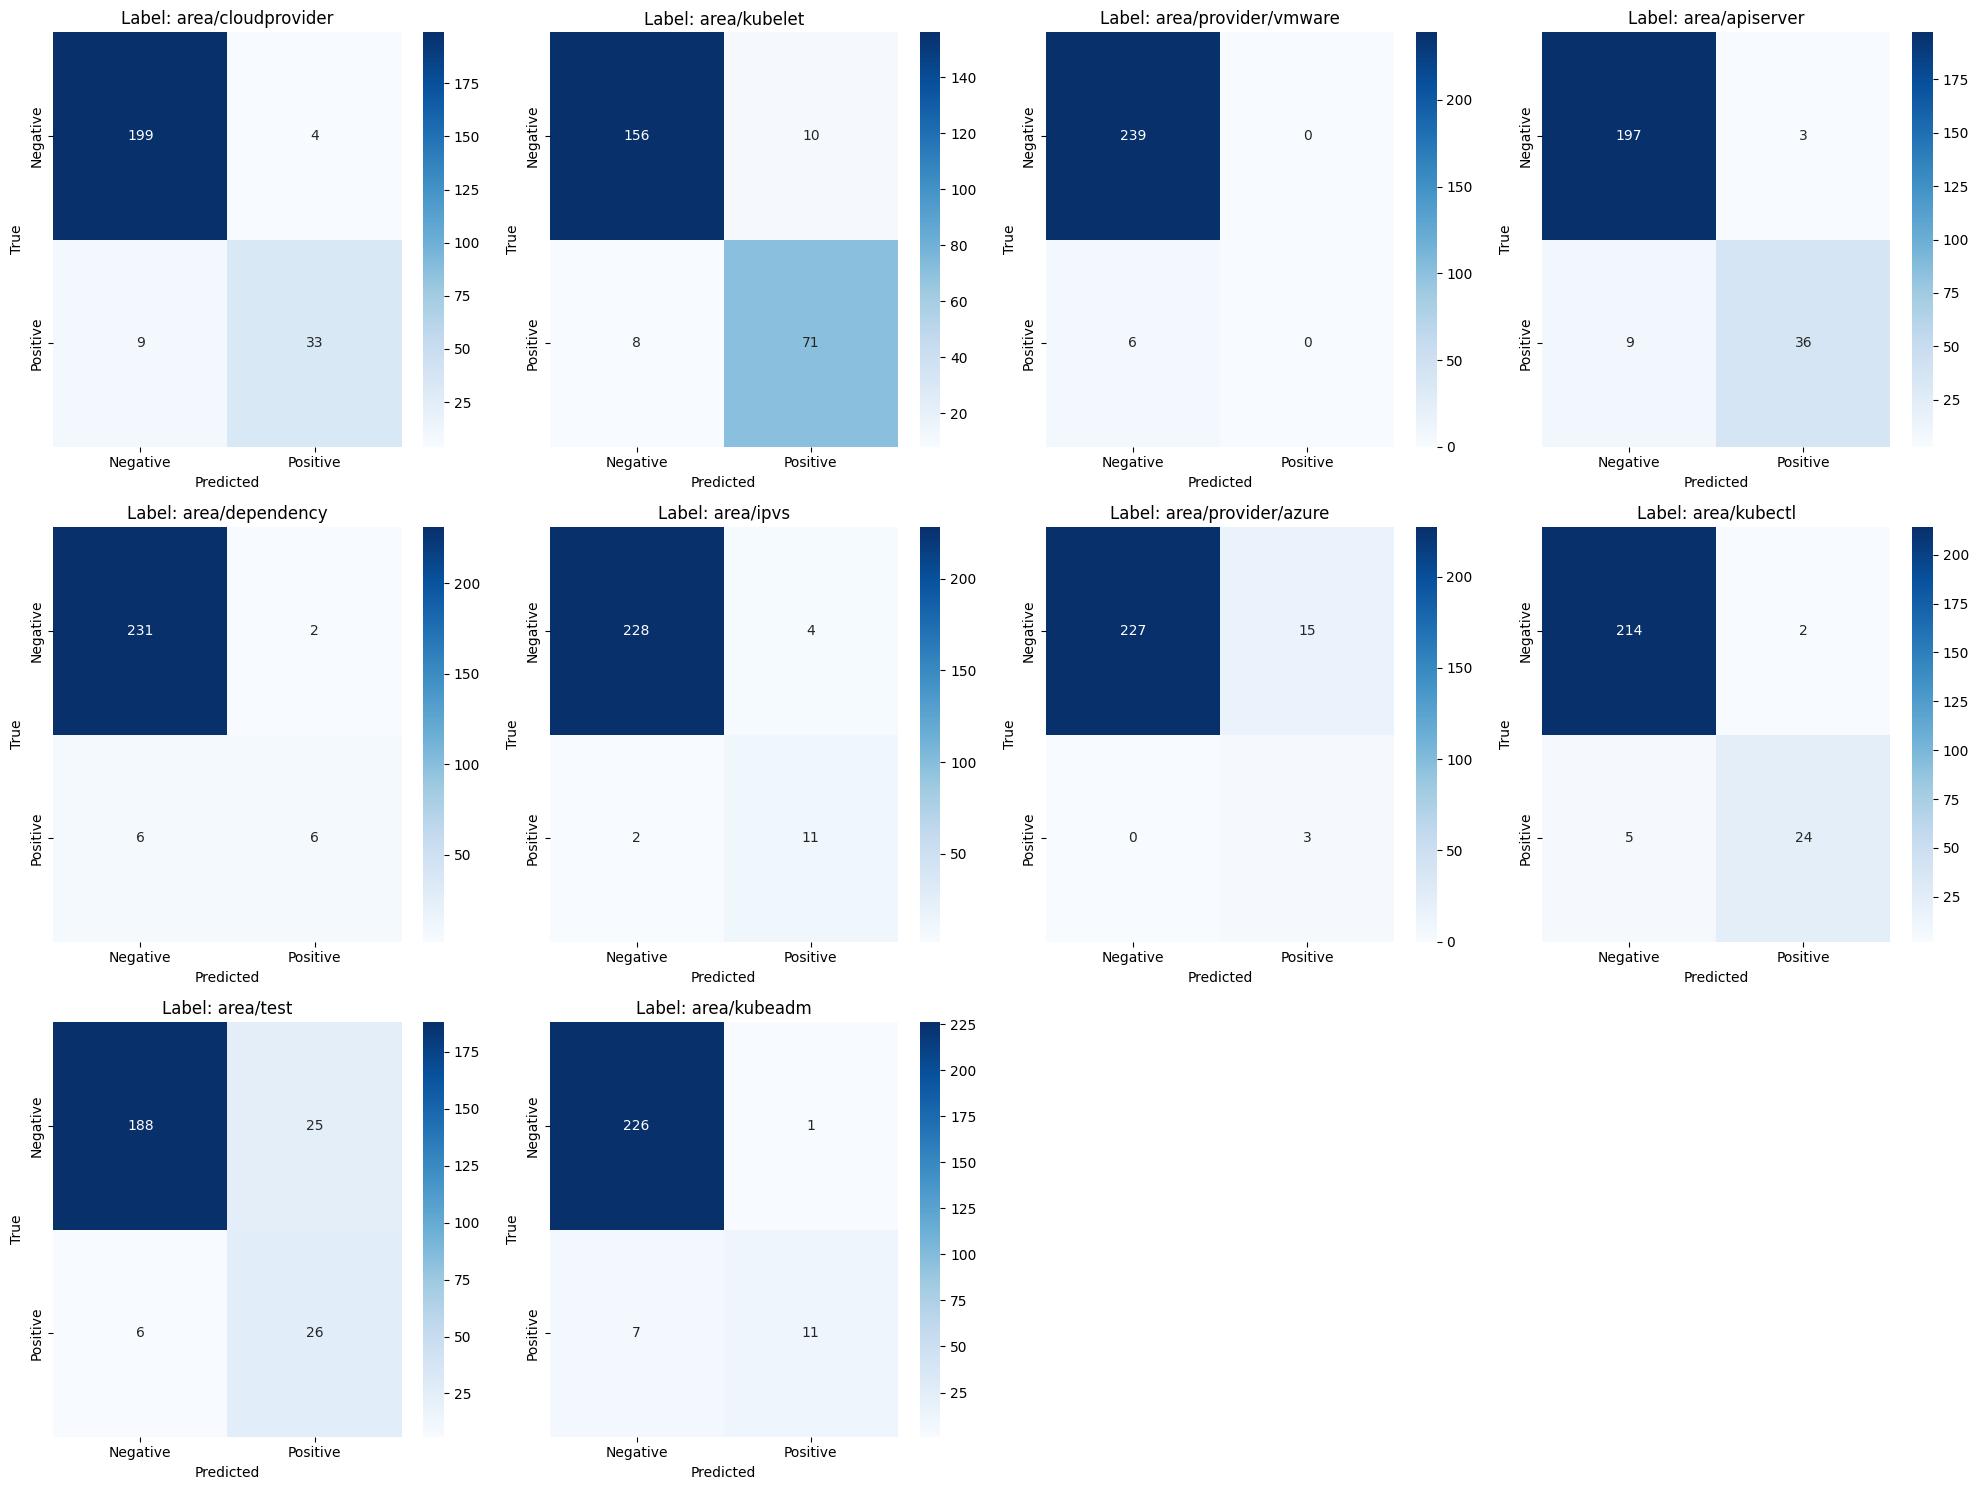

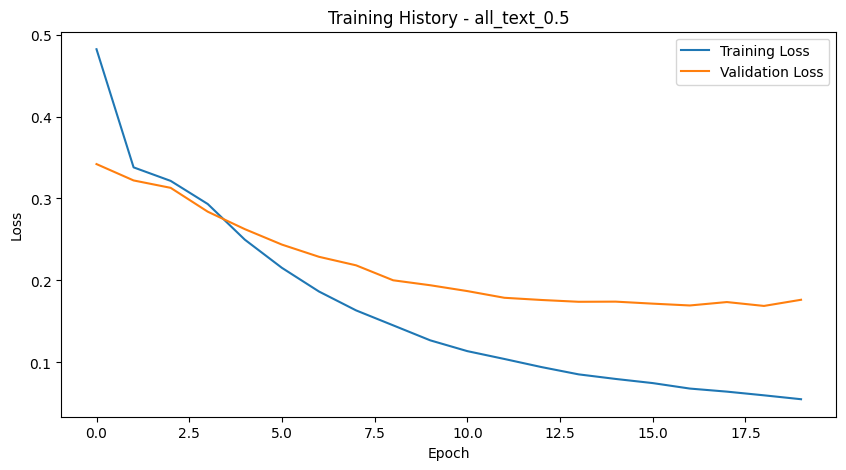

In [13]:
if __name__ == "__main__":
    # Create parser and handle Jupyter/Colab environment by ignoring unknown args
    parser = argparse.ArgumentParser(description='Train CodeBERT for multi-label classification')
    
    # Data parameters
    parser.add_argument('--data_path', type=str, 
                        default="/kaggle/input/kubernetes-final-bug-data-without-comments/cleaned_data_with_changed_files_no_comments.json",
                        help='Path to the JSON data file')
    parser.add_argument('--text_column', type=str, default='all_text_0.5',
                        help='Column name with the text data to use for training (e.g., all_text, all_text_0.5)')
    parser.add_argument('--results_dir', type=str, default='./results',
                        help='Directory to save results')
    
    # Label filtering parameters
    parser.add_argument('--min_label_freq', type=int, default=5,
                        help='Minimum frequency for a label to be considered')
    parser.add_argument('--max_label_len', type=int, default=5,
                        help='Maximum number of labels per sample')
    parser.add_argument('--min_label_comb_freq', type=int, default=0,
                        help='Minimum frequency for a label combination')
    
    # Training parameters
    parser.add_argument('--batch_size', type=int, default=16, help='Training batch size')
    parser.add_argument('--epochs', type=int, default=20, help='Number of training epochs')
    parser.add_argument('--learning_rate', type=float, default=2e-5, help='Learning rate')
    parser.add_argument('--patience', type=int, default=3, help='Early stopping patience')
    parser.add_argument('--use_class_weights', action='store_true', help='Use class weights for imbalanced data')
    
    # Feature selection parameters
    # Enable feature selection by default
    parser.add_argument('--feature_selection', action='store_true', 
                        help='Enable hybrid feature selection', default=True)
    parser.add_argument('--filter_k', type=int, default=20, 
                        help='Number of labels to retain after filter stage')
    parser.add_argument('--final_k', type=int, default=10, 
                        help='Final number of labels to select')
    parser.add_argument('--vectorizer', type=str, choices=['count', 'tfidf'], default='tfidf',
                        help='Vectorizer to use for feature selection')
    
    # Parse arguments, ignore unknown args for compatibility with Jupyter/Colab
    args, unknown = parser.parse_known_args()
    
    # If the script is run directly, not imported
    results = main(args)